# R3 - Clustering Algorithms and Evaluation
In this notebook, we will explore various clustering algorithms, including K-Means, DBSCAN, and Birch. We will also evaluate their performance using metrics such as silhouette score, Davies-Bouldin index, and Calinski-Harabasz index. The clustering results will be visualized to better understand how the data points are grouped.

---
## Importing libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, Birch
from scipy.cluster.hierarchy import dendrogram, linkage

## Load and Preprocess Data

Before we start clustering, let's load and preprocess the dataset.

In [2]:
# Loading and preprocessing the data
def load_and_preprocess_data(preprocessed_data_dir):
    """
    Load and preprocess preprocessed data for clustering.
    """
    # Load preprocessed data
    X_train = pd.read_csv(os.path.join(preprocessed_data_dir, 'X_train.csv'))
    X_valid = pd.read_csv(os.path.join(preprocessed_data_dir, 'X_valid.csv'))
    X_test = pd.read_csv(os.path.join(preprocessed_data_dir, 'X_test.csv'))

    # Combine datasets
    X_combined = pd.concat([X_train, X_valid, X_test], axis=0).reset_index(drop=True)

    # Identify categorical and numerical features
    categorical_cols = X_combined.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = X_combined.select_dtypes(include=[np.number]).columns.tolist()

    # Handle categorical features
    if categorical_cols:
        # Updated parameter: Replace 'sparse=False' with 'sparse_output=False'
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        X_cat = encoder.fit_transform(X_combined[categorical_cols])
        cat_feature_names = encoder.get_feature_names_out(categorical_cols)
        X_cat = pd.DataFrame(X_cat, columns=cat_feature_names)
    else:
        X_cat = pd.DataFrame()

    # Scale numerical features
    if numerical_cols:
        scaler = StandardScaler()
        X_num = scaler.fit_transform(X_combined[numerical_cols])
        X_num = pd.DataFrame(X_num, columns=numerical_cols)
    else:
        X_num = pd.DataFrame()

    # Combine numerical and categorical features
    if not X_cat.empty and not X_num.empty:
        X_processed = pd.concat([X_num, X_cat], axis=1)
    elif not X_num.empty:
        X_processed = X_num
    else:
        X_processed = X_cat

    return X_processed

# Specify the directory where preprocessed data is stored
preprocessed_data_dir = '../Datasets/preprocessed_data/delivery'  # Adjust as needed

# Load and preprocess the data
X_processed = load_and_preprocess_data(preprocessed_data_dir)

### Plotting clusters function
This function visualizes clusters by reducing the dataset's dimensionality to 2D using Principal Component Analysis (PCA).
- It generates a scatter plot with clusters distinguished by colors.
- This function is ideal for visualizing and interpreting clustering results, especially when comparing different clustering methods.

In [3]:
def plot_clusters(data, labels, method_name, results_dir=None):
    """
    Plot clusters using PCA for dimensionality reduction to 2D.
    The legend is placed below the plot, spanning maximum width without exceeding image width.
    """
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    cluster_df = pd.DataFrame(data_2d, columns=['PC1', 'PC2'])
    cluster_df['Cluster'] = labels

    unique_clusters = cluster_df['Cluster'].nunique()
    
    # Determine if the method is DBSCAN
    is_dbscan = method_name.lower() == 'dbscan'
    
    # Fixed figure size
    plt.figure(figsize=(10, 8))
    
    # Choose a color palette that can handle more colors if necessary
    if unique_clusters > 10:
        palette = sns.color_palette("hsv", unique_clusters)
    else:
        palette = 'tab10'
    
    scatter = sns.scatterplot(
        x='PC1', y='PC2', hue='Cluster', palette=palette, data=cluster_df, legend=False, s=30
    )
    plt.title(f'{method_name} Clustering Visualization (PCA 2D)', fontsize=14)
    
    # Create a separate legend below the plot
    handles, _ = scatter.get_legend_handles_labels()
    # Determine the number of columns for the legend
    if unique_clusters <= 10:
        ncol = 2
    elif unique_clusters <= 20:
        ncol = 4
    elif unique_clusters <= 50:
        ncol = 6
    else:
        ncol = 10  # Max columns to prevent exceeding image width

    plt.legend(handles=handles, labels=cluster_df['Cluster'].unique(),
               title='Cluster', fontsize=10, title_fontsize=12,
               bbox_to_anchor=(0.5, -0.15), loc='upper center',
               ncol=ncol, borderaxespad=0.)
    
    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to make space for the legend
    if results_dir:
        plt.savefig(os.path.join(results_dir, f"{method_name.lower()}_clusters.png"), bbox_inches='tight')
    plt.show()

### Cluster Profile Function

This function generates a cluster profile by calculating the mean feature values for each cluster.
- It helps in understanding the key characteristics of different clusters.

In [4]:
def cluster_profile(data, labels, method_name, results_dir=None):
    """
    Generate cluster profiles by calculating mean feature values for each cluster.
    """
    data_with_labels = data.copy()
    data_with_labels['Cluster'] = labels
    cluster_profiles = data_with_labels.groupby('Cluster').mean()

    if results_dir:
        profile_file = os.path.join(results_dir, f"{method_name.lower()}_cluster_profiles.csv")
        cluster_profiles.to_csv(profile_file)
        print(f"{method_name} cluster profiles saved to {profile_file}")

    print(f"\n{method_name} Cluster Profiles:")
    print(cluster_profiles)

### Cluster Count Plot Function

This function visualizes the distribution of data points across clusters by creating a bar plot. 
It provides insights into the size of each cluster.

In [5]:
def plot_cluster_counts(labels, method_name, results_dir=None):
    """
    Plot the count of data points in each cluster.
    Use a logarithmic scale for better readability of large count disparities.
    """
    cluster_counts = pd.Series(labels).value_counts().sort_index()
    num_clusters = cluster_counts.shape[0]
    
    # Determine if we should display value labels
    display_value_labels = num_clusters <= 100  # Adjust this threshold as needed

    # Switch to horizontal bar plot for better readability with many clusters
    plt.figure(figsize=(12, max(8, num_clusters * 0.02)))  # Adjust height based on number of clusters
    sns.set_style("whitegrid")
    
    # Use a single, solid color for all bars to enhance visibility
    bar_plot = sns.barplot(
        x=cluster_counts.values, 
        y=cluster_counts.index.astype(str), 
        color='steelblue',  # Solid color for visibility
    )
    
    plt.title(f'{method_name} Cluster Counts', fontsize=14)
    plt.xlabel("Number of Data Points (Log Scale)", fontsize=12)
    plt.ylabel("Cluster", fontsize=12)
    
    # Apply logarithmic scale for better readability
    plt.xscale("log")
    plt.grid(axis='x', linestyle='--', linewidth=0.5)  # Add gridlines for x-axis

    # Limit the number of y-ticks to prevent label clutter
    if num_clusters > 100:
        # Show labels for every 50th cluster
        tick_positions = range(0, num_clusters, 50)
        tick_labels = [str(cluster_counts.index[i]) if i < num_clusters else "" for i in tick_positions]
        bar_plot.set_yticks(tick_positions)
        bar_plot.set_yticklabels(tick_labels)
    elif num_clusters > 50:
        # Show labels for every 10th cluster
        tick_positions = range(0, num_clusters, 10)
        tick_labels = [str(cluster_counts.index[i]) if i < num_clusters else "" for i in tick_positions]
        bar_plot.set_yticks(tick_positions)
        bar_plot.set_yticklabels(tick_labels)
    else:
        # Show all labels
        bar_plot.set_yticks(range(num_clusters))
        bar_plot.set_yticklabels([str(cluster) for cluster in cluster_counts.index], fontsize=8)

    # Adjust y-axis label font size
    plt.yticks(fontsize=6)

    # Add value labels on the bars if the number of clusters is manageable
    if display_value_labels:
        for index, value in enumerate(cluster_counts.values):
            plt.text(value + max(cluster_counts.values)*0.01, index, str(value), va='center', fontsize=6)

    plt.tight_layout()  # Adjust layout to prevent clipping
    if results_dir:
        plt.savefig(os.path.join(results_dir, f"{method_name.lower()}_cluster_counts.png"), bbox_inches='tight')
    plt.show()

### Plotting Silhouette Scores

This function visualizes silhouette scores across a range of cluster numbers to help evaluate clustering performance and determine the optimal number of clusters.

In [6]:
def plot_silhouette_scores(cluster_range, silhouette_scores, method, results_dir=None):
    """
    Plot silhouette scores for different numbers of clusters.
    """
    plt.figure(figsize=(10, 6))  # Increased figure size
    plt.plot(cluster_range, silhouette_scores, marker='o')
    plt.title(f'{method} Clustering Silhouette Scores', fontsize=14)
    plt.xlabel("Number of Clusters", fontsize=12)
    plt.ylabel("Silhouette Score", fontsize=12)
    plt.xticks(cluster_range, fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)
    if results_dir:
        plt.savefig(os.path.join(results_dir, f"{method.lower()}_silhouette_scores.png"), bbox_inches='tight')
    plt.show()

# K-Means Clustering
First, we implement the K-Means clustering algorithm. 
- This algorithm is known for its simplicity and efficiency.
- We'll evaluate the clustering using the Elbow method and silhouette scores to determine the optimal number of clusters.


In [7]:
def kmeans_clustering(data, max_clusters=10, results_dir=None):
    sse = []
    silhouette_scores = []
    cluster_range = range(2, max_clusters + 1)

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))

    # Plot Inertia (Elbow Method)
    plt.figure(figsize=(10, 6))  # Increased figure size
    plt.plot(cluster_range, sse, marker='o')
    plt.title("K-Means Elbow Method", fontsize=14)
    plt.xlabel("Number of Clusters", fontsize=12)
    plt.ylabel("Inertia (SSE)", fontsize=12)
    plt.xticks(cluster_range, fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)
    if results_dir:
        plt.savefig(os.path.join(results_dir, "kmeans_elbow_method.png"), bbox_inches='tight')
    plt.show()

    # Plot Silhouette Scores
    plot_silhouette_scores(cluster_range, silhouette_scores, "K-Means", results_dir)

    # Choose optimal k
    optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2  # +2 because range starts at 2
    print(f"Optimal number of clusters determined by silhouette score: {optimal_k}")

    # Fit KMeans with optimal_k
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    labels = kmeans.fit_predict(data)

    # Save cluster labels
    cluster_results = pd.DataFrame(labels, columns=['Cluster'])
    if results_dir:
        cluster_results.to_csv(os.path.join(results_dir, "kmeans_clusters.csv"), index=False)
        print("K-Means clustering results saved.")

    # Plot clusters
    plot_clusters(data, labels, "K-Means", results_dir)
    plot_cluster_counts(labels, "K-Means", results_dir)

    # Generate cluster profiles
    cluster_profile(data, labels, "K-Means", results_dir)

    return labels

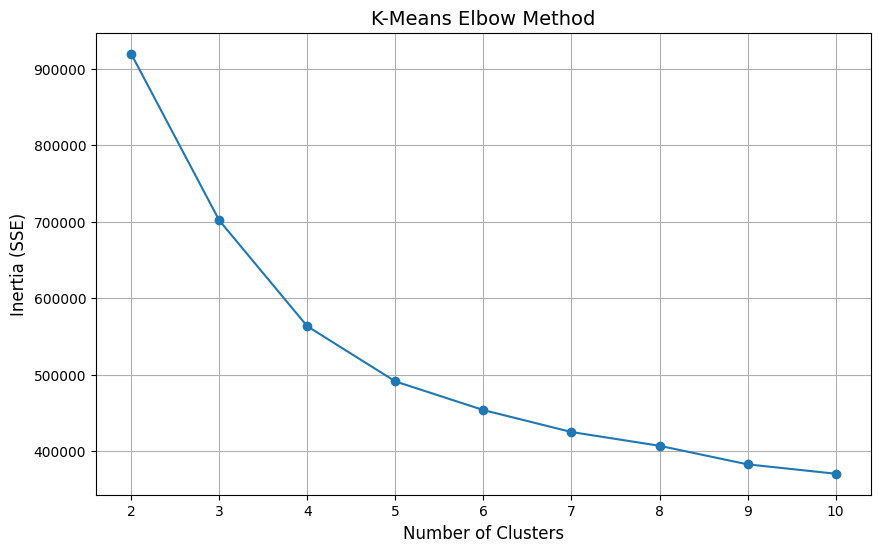

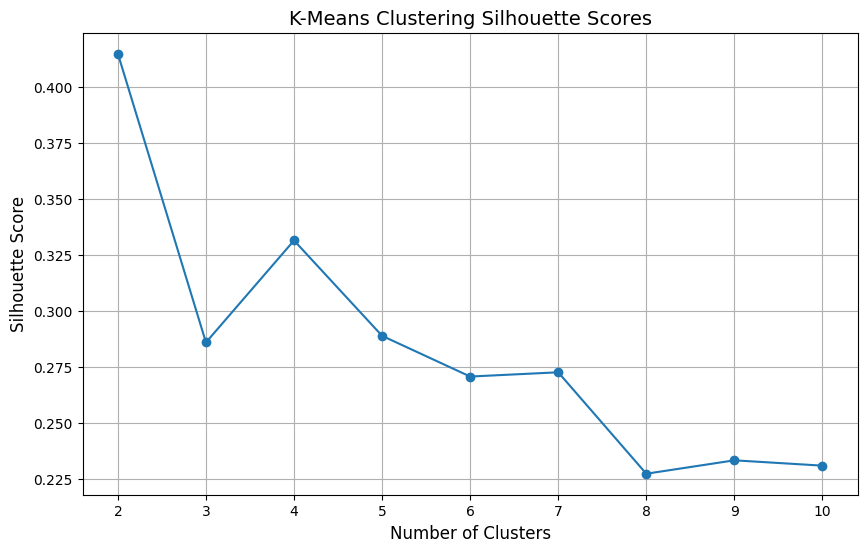

Optimal number of clusters determined by silhouette score: 2


C:\Users\saisu\AppData\Local\Temp\ipykernel_39660\3134154817.py:42: UserWarning: Mismatched number of handles and labels: len(handles) = 0 len(labels) = 2
  plt.legend(handles=handles, labels=cluster_df['Cluster'].unique(),
C:\Users\saisu\AppData\Local\Temp\ipykernel_39660\3134154817.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(handles=handles, labels=cluster_df['Cluster'].unique(),


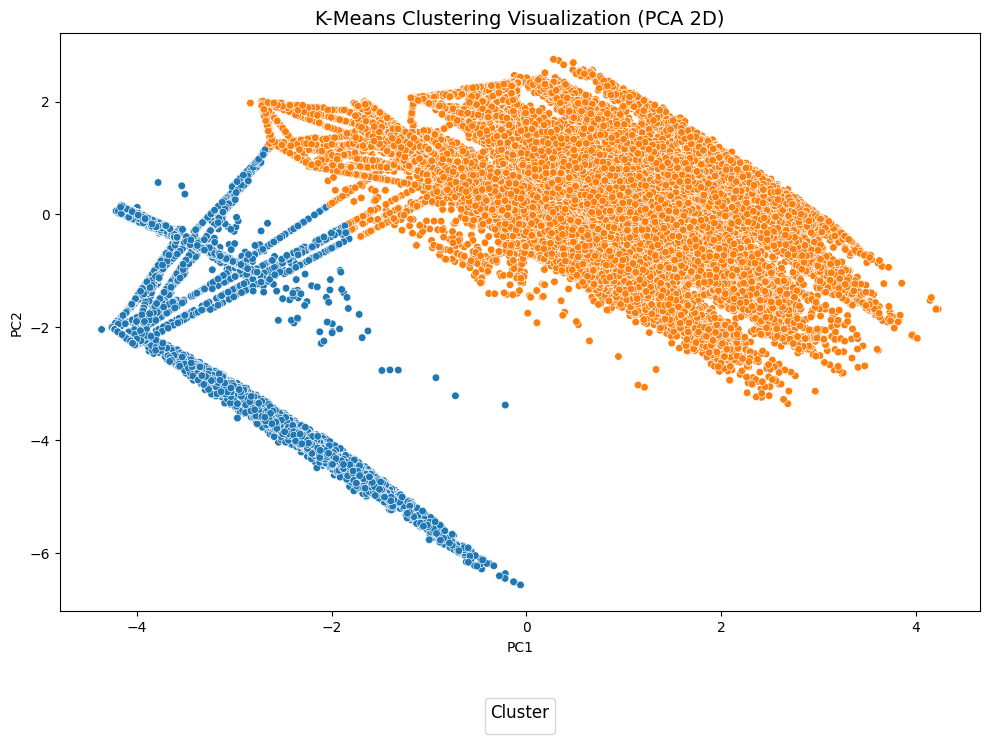

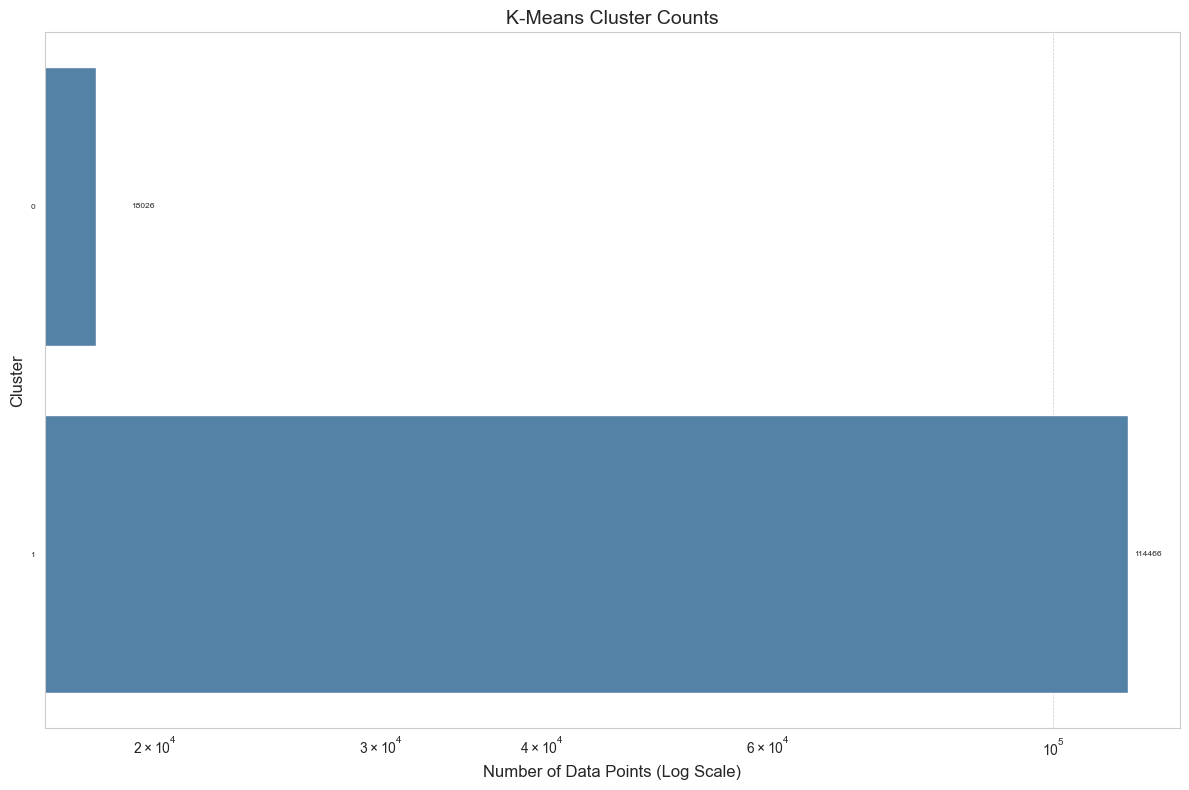


K-Means Cluster Profiles:
         Time_taken (min)  Delivery_person_Age  Restaurant_latitude  \
Cluster                                                               
0               -0.158302            -0.500795            -1.849397   
1                0.024929             0.078865             0.291241   

         Restaurant_longitude  Delivery_location_latitude  \
Cluster                                                     
0                   -2.334376                   -1.257976   
1                    0.367615                    0.198105   

         Delivery_location_longitude  Vehicle_condition  multiple_deliveries  \
Cluster                                                                        
0                          -1.720982           0.501329            -0.097393   
1                           0.271019          -0.078949             0.015337   

         Weather_conditions_Cloudy  Weather_conditions_Fog  ...  \
Cluster                                                

In [8]:
# Run K-Means clustering
kmeans_labels = kmeans_clustering(X_processed, max_clusters=10, results_dir=None)

# DBSCAN Clustering

Next, we implement the DBSCAN algorithm. DBSCAN does not require specifying the number of clusters beforehand, but instead relies on density-based criteria to form clusters.


In [9]:
def dbscan_clustering(data, eps_values=[0.3, 0.5, 0.7, 0.9], min_samples_values=[5, 10, 15], results_dir=None):
    best_score = -1
    best_eps = None
    best_min_samples = None
    best_labels = None

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(data)

            unique_labels = set(labels)
            n_clusters = len(unique_labels) - (1 if -1 in labels else 0)

            if n_clusters > 1:
                non_noise_mask = labels != -1
                try:
                    score = silhouette_score(data[non_noise_mask], labels[non_noise_mask])
                    if score > best_score:
                        best_score = score
                        best_eps = eps
                        best_min_samples = min_samples
                        best_labels = labels
                except:
                    continue

    if best_labels is not None:
        print(f"Best DBSCAN parameters: eps={best_eps}, min_samples={best_min_samples}")
        print(f"Best Silhouette Score: {best_score:.3f}")
        labels = best_labels
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # Save cluster labels
        cluster_results = pd.DataFrame(labels, columns=['Cluster'])
        if results_dir:
            cluster_results.to_csv(os.path.join(results_dir, "dbscan_clusters.csv"), index=False)
            print("DBSCAN clustering results saved.")

        # Plot clusters (excluding noise)
        non_noise_mask = labels != -1
        if n_clusters > 1:
            plot_clusters(data[non_noise_mask], labels[non_noise_mask], "DBSCAN", results_dir)
            plot_cluster_counts(labels[non_noise_mask], "DBSCAN", results_dir)
            # Generate cluster profiles
            cluster_profile(data.iloc[non_noise_mask], labels[non_noise_mask], "DBSCAN", results_dir)
        else:
            print("Skipping cluster plot for DBSCAN due to insufficient clusters.")
    else:
        print("DBSCAN did not find sufficient clusters with the given parameter ranges.")
        labels = None

    return labels

Best DBSCAN parameters: eps=0.3, min_samples=15
Best Silhouette Score: 0.143


C:\Users\saisu\AppData\Local\Temp\ipykernel_39660\3134154817.py:42: UserWarning: Mismatched number of handles and labels: len(handles) = 0 len(labels) = 437
  plt.legend(handles=handles, labels=cluster_df['Cluster'].unique(),
C:\Users\saisu\AppData\Local\Temp\ipykernel_39660\3134154817.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(handles=handles, labels=cluster_df['Cluster'].unique(),


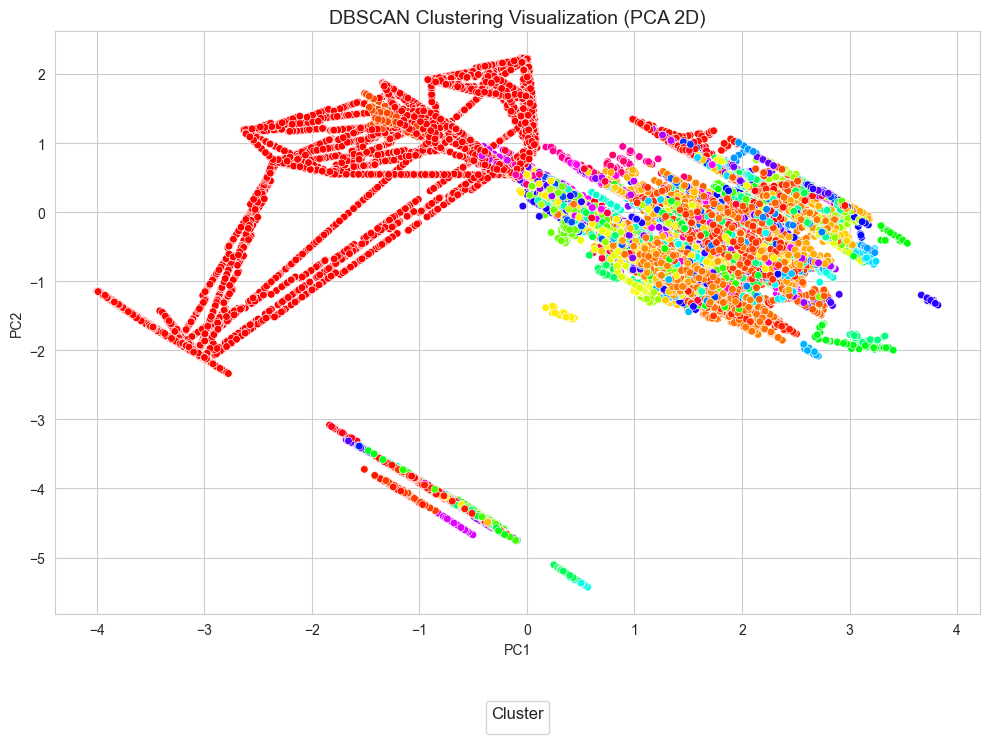

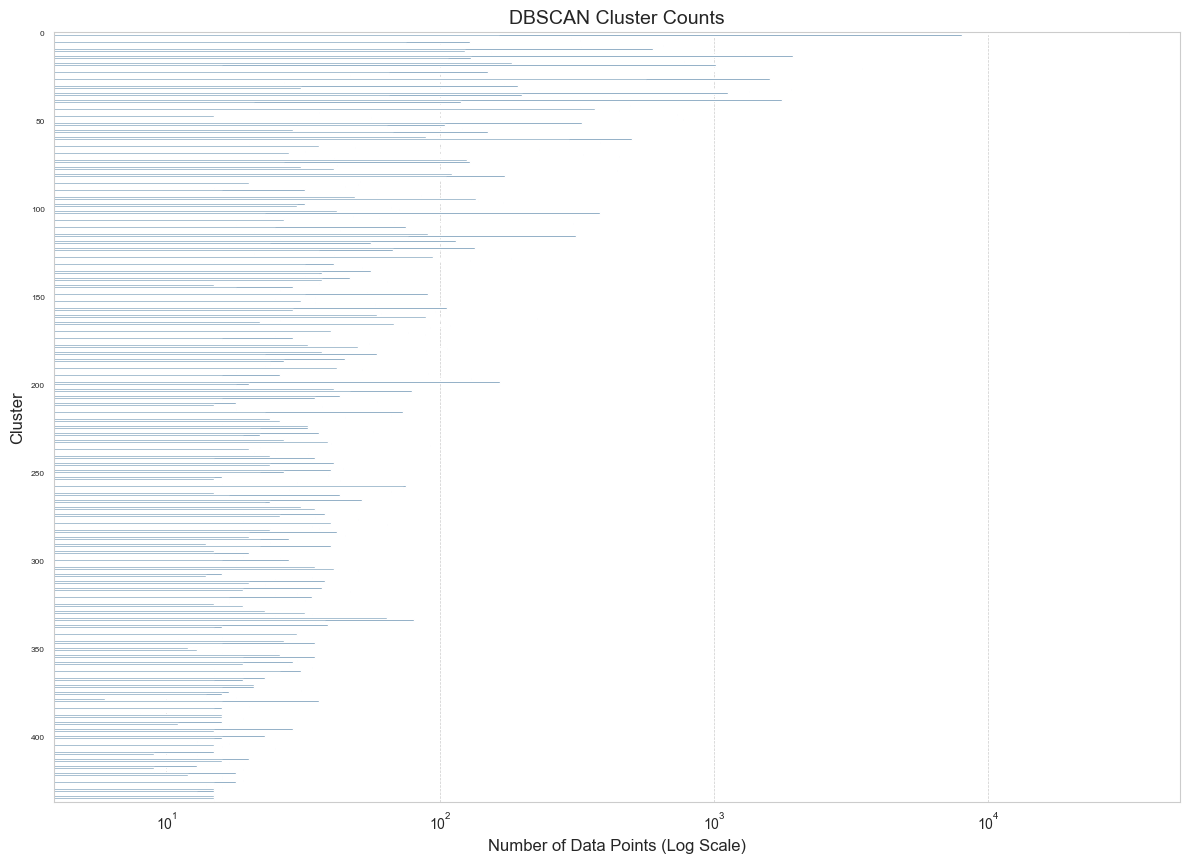


DBSCAN Cluster Profiles:
         Time_taken (min)  Delivery_person_Age  Restaurant_latitude  \
Cluster                                                               
0               -0.442884            -1.212031            -0.174063   
1               -0.380729            -1.212031            -2.573961   
2                0.195704             1.113006             1.105321   
3                0.418012            -0.452580             1.168820   
4                0.592135             0.107585            -1.177204   
...                   ...                  ...                  ...   
432             -0.441109             0.370385             1.130183   
433             -1.571945             0.047756            -0.148490   
434              0.925317             1.158426             0.789176   
435             -1.571945             1.215365            -0.118410   
436             -1.281383             0.616197            -1.177204   

         Restaurant_longitude  Delivery_location_l

In [10]:
# Run DBSCAN clustering
dbscan_labels = dbscan_clustering(X_processed, eps_values=[0.3, 0.5, 0.7, 0.9], min_samples_values=[5, 10, 15], results_dir=None)

# Birch Clustering

Finally, we implement the Birch clustering algorithm, which is particularly effective for large datasets. 
- Birch performs hierarchical clustering to identify subclusters.
- We will try different values for `threshold` and `n_clusters` and evaluate the results.

In [11]:
def plot_birch_dendrogram(birch_model, data, method_name, results_dir=None):
    """
    Plot a dendrogram for the Birch clustering.

    Parameters:
    - birch_model: The trained Birch model.
    - data: The dataset used for clustering.
    - method_name: Name of the clustering method (e.g., "Birch").
    - results_dir: Directory to save the dendrogram plot.
    """
    # Extract the subcluster centroids
    subcluster_centers = birch_model.subcluster_centers_

    # Perform hierarchical clustering on the subcluster centroids
    linked = linkage(subcluster_centers, method='ward')

    # Plot dendrogram
    plt.figure(figsize=(15, 8))  # Increased figure size to accommodate more labels
    dendrogram(
        linked,
        orientation='top',
        distance_sort='descending',
        show_leaf_counts=True,
        no_labels=True,  # Hide leaf labels to prevent overlap
    )
    plt.title(f'{method_name} Clustering Dendrogram', fontsize=16)
    plt.xlabel('Subcluster Index', fontsize=12)
    plt.ylabel('Distance', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()  # Adjust layout to prevent clipping
    if results_dir:
        plt.savefig(os.path.join(results_dir, f"{method_name.lower()}_dendrogram.png"), bbox_inches='tight')
        print(f"{method_name} dendrogram plot saved.")
    plt.show()

In [12]:
def birch_clustering(data, threshold_values=[0.3, 0.5, 0.7], n_clusters_values=[2, 3, 4, 5, 6], results_dir=None):
    best_score = -1
    best_threshold = None
    best_n_clusters = None
    best_labels = None
    best_model = None

    for threshold in threshold_values:
        for n_clusters in n_clusters_values:
            birch_model = Birch(threshold=threshold, n_clusters=n_clusters)
            labels = birch_model.fit_predict(data)
            unique_labels = set(labels)
            n_clusters_estimated = len(unique_labels)

            if n_clusters_estimated > 1:
                try:
                    score = silhouette_score(data, labels)
                    if score > best_score:
                        best_score = score
                        best_threshold = threshold
                        best_n_clusters = n_clusters
                        best_labels = labels
                        best_model = birch_model
                except:
                    continue

    if best_labels is not None:
        print(f"Best Birch parameters: threshold={best_threshold}, n_clusters={best_n_clusters}")
        print(f"Best Silhouette Score: {best_score:.3f}")
        labels = best_labels

        # Save cluster labels
        cluster_results = pd.DataFrame(labels, columns=['Cluster'])
        if results_dir:
            cluster_results.to_csv(os.path.join(results_dir, "birch_clusters.csv"), index=False)
            print("Birch clustering results saved.")

        # Plot clusters
        plot_clusters(data, labels, "Birch", results_dir)
        plot_cluster_counts(labels, "Birch", results_dir)

        # Generate cluster profiles
        cluster_profile(data, labels, "Birch", results_dir)

        # Plot dendrogram
        plot_birch_dendrogram(best_model, data, "Birch", results_dir)
    else:
        print("Birch did not find sufficient clusters with the given parameter ranges.")
        labels = None

    return labels

Best Birch parameters: threshold=0.7, n_clusters=2
Best Silhouette Score: 0.410


C:\Users\saisu\AppData\Local\Temp\ipykernel_39660\3134154817.py:42: UserWarning: Mismatched number of handles and labels: len(handles) = 0 len(labels) = 2
  plt.legend(handles=handles, labels=cluster_df['Cluster'].unique(),
C:\Users\saisu\AppData\Local\Temp\ipykernel_39660\3134154817.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(handles=handles, labels=cluster_df['Cluster'].unique(),


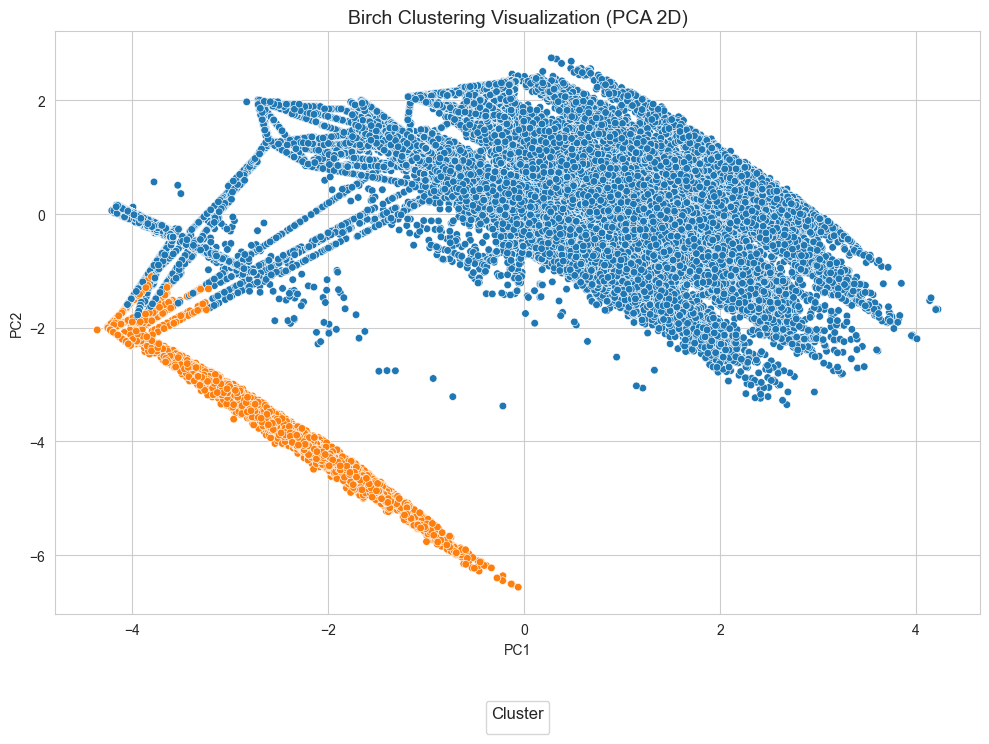

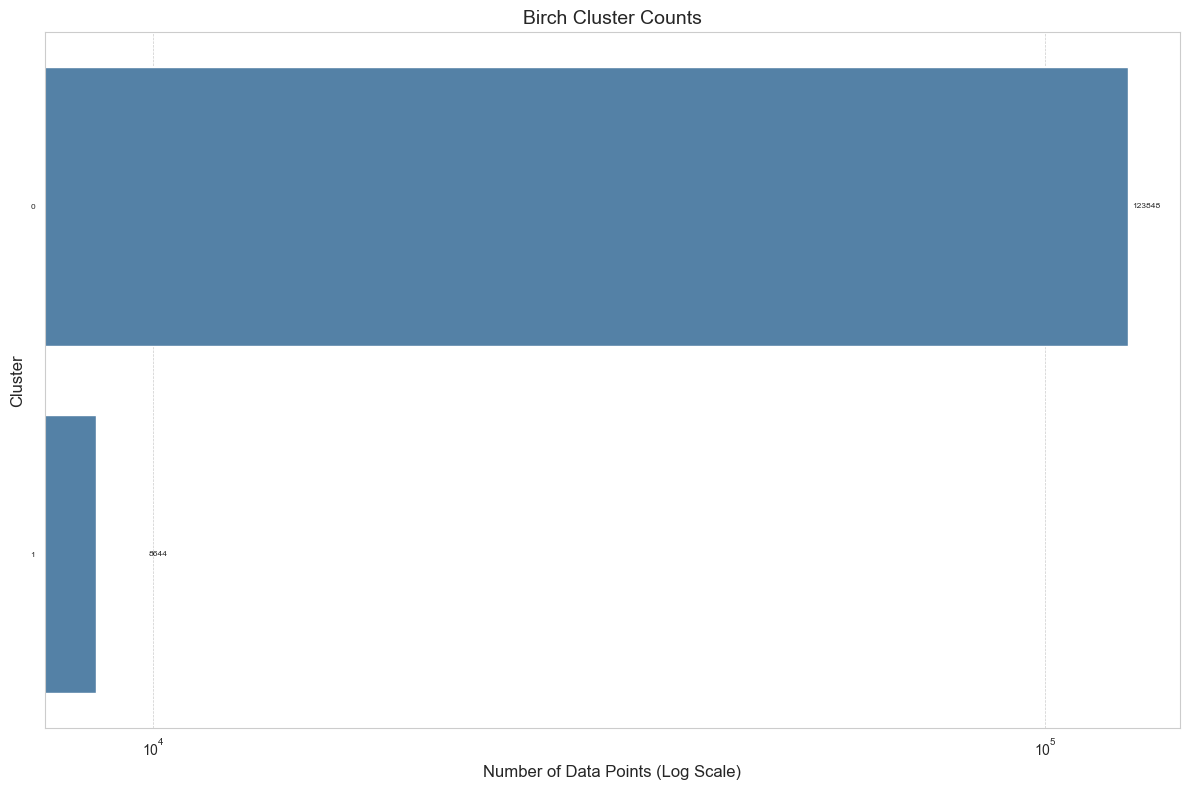


Birch Cluster Profiles:
         Time_taken (min)  Delivery_person_Age  Restaurant_latitude  \
Cluster                                                               
0               -0.005906            -0.017042             0.082345   
1                0.084617             0.244172            -1.179802   

         Restaurant_longitude  Delivery_location_latitude  \
Cluster                                                     
0                    0.104311                    0.170792   
1                   -1.494532                   -2.447039   

         Delivery_location_longitude  Vehicle_condition  multiple_deliveries  \
Cluster                                                                        
0                           0.255387           0.016291             0.006407   
1                          -3.659091          -0.233415            -0.091795   

         Weather_conditions_Cloudy  Weather_conditions_Fog  ...  \
Cluster                                                  

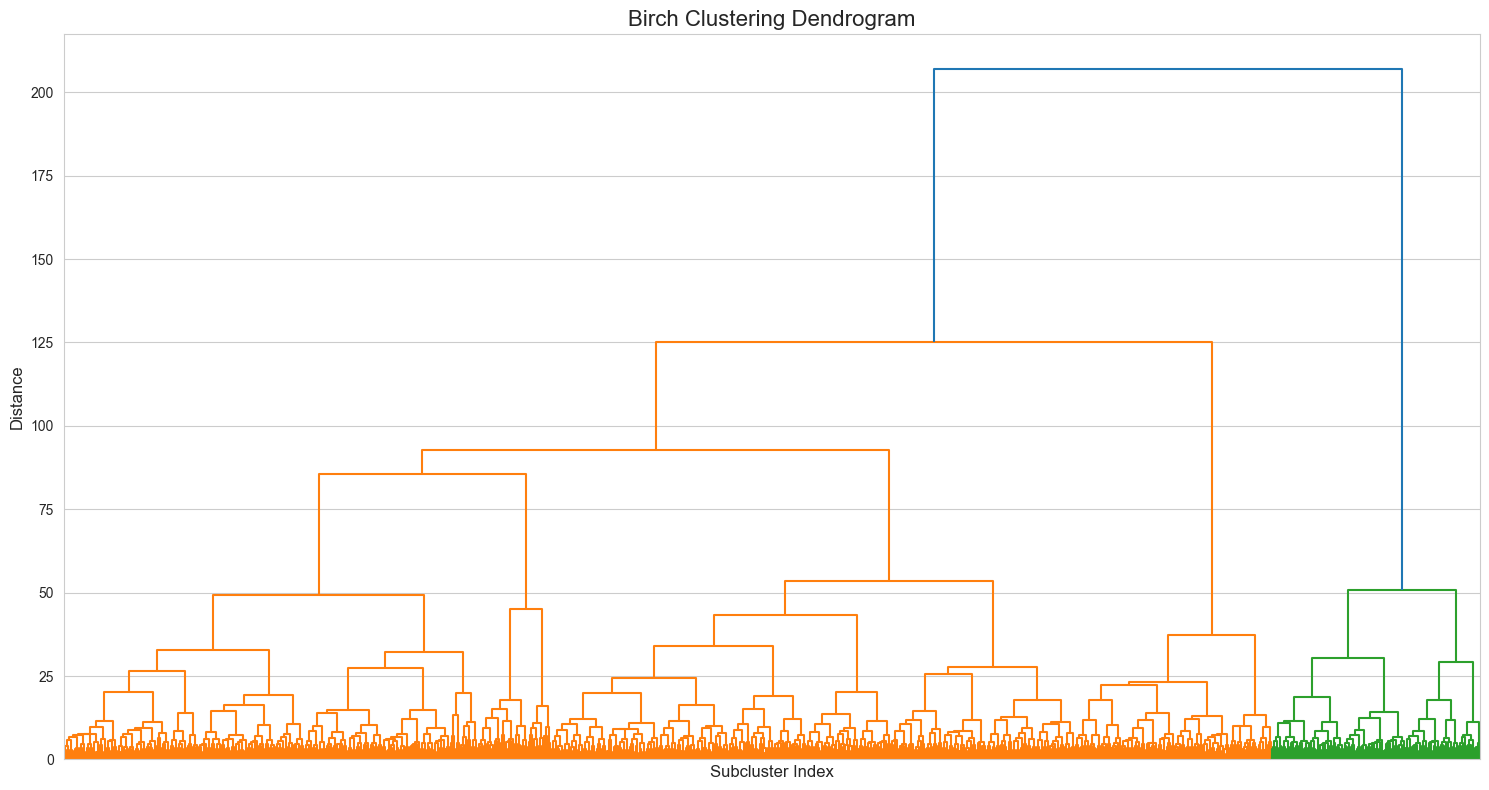

In [13]:
# Run Birch clustering
birch_labels = birch_clustering(X_processed, threshold_values=[0.3, 0.5, 0.7], n_clusters_values=[2, 3, 4, 5, 6], results_dir=None)

# Running the Clustering Algorithms

Let's run the clustering algorithms on a user-selected dataset and visualize the results.

In [14]:
def evaluate_clustering(labels, data, method_name, results_dir=None):
    """
    Evaluate clustering results and save evaluation metrics.
    """
    silhouette_avg = silhouette_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    calinski_harabasz = calinski_harabasz_score(data, labels)

    results = (
        f"{method_name} Clustering Evaluation:\n"
        f" - Silhouette Score: {silhouette_avg:.3f}\n"
        f" - Davies-Bouldin Index: {davies_bouldin:.3f}\n"
        f" - Calinski-Harabasz Index: {calinski_harabasz:.3f}\n"
    )
    print(results)

    if results_dir:
        eval_file = os.path.join(results_dir, f"{method_name.lower()}_evaluation.txt")
        with open(eval_file, 'w') as f:
            f.write(results)
        print(f"{method_name} evaluation metrics saved to {eval_file}")

    # Return metrics for comparison
    return {
        'method': method_name,
        'silhouette_score': silhouette_avg,
        'davies_bouldin_index': davies_bouldin,
        'calinski_harabasz_index': calinski_harabasz,
    }

In [15]:
def ensure_directory(directory):
    """
    Ensure that the directory exists.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)

In [16]:
def compare_algorithms(comparison_metrics, results_dir):
    """
    Compare clustering algorithms based on evaluation metrics.
    """
    df_metrics = pd.DataFrame(comparison_metrics)
    print("\nComparison of Clustering Algorithms:")
    print(df_metrics[['method', 'silhouette_score', 'davies_bouldin_index', 'calinski_harabasz_index']])

    # Save comparison table
    if results_dir:
        df_metrics.to_csv(os.path.join(results_dir, "clustering_algorithms_comparison.csv"), index=False)
        print(f"Comparison metrics saved to {os.path.join(results_dir, 'clustering_algorithms_comparison.csv')}")

    # Plot comparison of Silhouette Scores
    plt.figure(figsize=(10, 6))  # Increased figure size
    sns.barplot(x='method', y='silhouette_score', data=df_metrics, palette='viridis')
    plt.title("Comparison of Clustering Algorithms - Silhouette Score", fontsize=14)
    plt.xlabel("Clustering Algorithm", fontsize=12)
    plt.ylabel("Silhouette Score", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    if results_dir:
        plt.savefig(os.path.join(results_dir, "clustering_algorithms_silhouette_comparison.png"), bbox_inches='tight')
    plt.show()

    # Plot comparison of Davies-Bouldin Index (lower is better)
    plt.figure(figsize=(10, 6))  # Increased figure size
    sns.barplot(x='method', y='davies_bouldin_index', data=df_metrics, palette='magma')
    plt.title("Comparison of Clustering Algorithms - Davies-Bouldin Index", fontsize=14)
    plt.xlabel("Clustering Algorithm", fontsize=12)
    plt.ylabel("Davies-Bouldin Index", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    if results_dir:
        plt.savefig(os.path.join(results_dir, "clustering_algorithms_davies_bouldin_comparison.png"), bbox_inches='tight')
    plt.show()

    # Plot comparison of Calinski-Harabasz Index (higher is better)
    plt.figure(figsize=(10, 6))  # Increased figure size
    sns.barplot(x='method', y='calinski_harabasz_index', data=df_metrics, palette='coolwarm')
    plt.title("Comparison of Clustering Algorithms - Calinski-Harabasz Index", fontsize=14)
    plt.xlabel("Clustering Algorithm", fontsize=12)
    plt.ylabel("Calinski-Harabasz Index", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    if results_dir:
        plt.savefig(os.path.join(results_dir, "clustering_algorithms_calinski_harabasz_comparison.png"), bbox_inches='tight')
    plt.show()

In [17]:
def main():
    # User selection for dataset type
    print("Select Dataset Type:")
    print("1. Delivery Dataset")
    print("2. Restaurant Dataset")
    dataset_choice = input("Enter the dataset number: ")

    if dataset_choice == "1":
        dataset_type = "delivery"
        dataset_name = "Delivery"
    elif dataset_choice == "2":
        dataset_type = "restaurant"
        dataset_name = "Restaurant"
    else:
        print("Invalid dataset choice.")
        return

    # Define the base directory where preprocessed data is stored
    base_dir = '../Datasets/preprocessed_data'  # Adjust the path as needed
    preprocessed_data_dir = os.path.join(base_dir, dataset_type)

    # Load and preprocess data
    X_processed = load_and_preprocess_data(preprocessed_data_dir)

    # Initialize a list to store evaluation metrics for comparison
    comparison_metrics = []

    # User selection for clustering method
    print("Select Clustering Method:")
    print("1. K-Means")
    print("2. DBSCAN")
    print("3. Birch")
    print("4. Run All and Compare")
    clustering_choice = input("Enter the clustering method number: ")

    if clustering_choice == "1":
        print("Running K-Means Clustering...")
        # Create results directory
        results_dir = f"Results/K_Means_Clustering_{dataset_name}"
        ensure_directory(results_dir)
        labels = kmeans_clustering(X_processed, max_clusters=10, results_dir=results_dir)
        metrics = evaluate_clustering(labels, X_processed, "K-Means", results_dir)
        comparison_metrics.append(metrics)
    elif clustering_choice == "2":
        print("Running DBSCAN Clustering with parameter tuning...")
        results_dir = f"Results/DBScan_Clustering_{dataset_name}"
        ensure_directory(results_dir)
        if dataset_type == "delivery": 
            min_samples_values = [5, 10, 15] 
        else: 
            min_samples_values = [5, 10, 15]  # Corrected the assignment
        labels = dbscan_clustering(
            X_processed,
            eps_values=[0.3, 0.5, 0.7, 0.9],
            min_samples_values=min_samples_values,  # Pass the min_samples_values correctly
            results_dir=results_dir
        )
        if labels is not None:
            non_noise_mask = labels != -1
            if len(set(labels[non_noise_mask])) > 1:
                metrics = evaluate_clustering(labels[non_noise_mask], X_processed.iloc[non_noise_mask], "DBSCAN", results_dir)
                comparison_metrics.append(metrics)
            else:
                print("DBSCAN did not find sufficient clusters to evaluate.")
        else:
            print("DBSCAN did not find suitable parameters.")
    elif clustering_choice == "3":
        print("Running Birch Clustering with parameter tuning...")
        results_dir = f"Results/Birch_Clustering_{dataset_name}"
        ensure_directory(results_dir)
        labels = birch_clustering(
            X_processed,
            threshold_values=[0.3, 0.5, 0.7],
            n_clusters_values=[2, 3, 4, 5, 6],
            results_dir=results_dir
        )
        if labels is not None:
            metrics = evaluate_clustering(labels, X_processed, "Birch", results_dir)
            comparison_metrics.append(metrics)
        else:
            print("Birch did not find suitable parameters.")
    elif clustering_choice == "4":
        print("Running all clustering algorithms for comparison...")
        results_dir = f"Results/Comparison_of_Clustering_{dataset_name}"
        ensure_directory(results_dir)

        # K-Means
        labels_kmeans = kmeans_clustering(X_processed, max_clusters=10, results_dir=results_dir)
        metrics_kmeans = evaluate_clustering(labels_kmeans, X_processed, "K-Means", results_dir)
        comparison_metrics.append(metrics_kmeans)

        # DBSCAN
        labels_dbscan = dbscan_clustering(
            X_processed,
            eps_values=[0.3, 0.5, 0.7, 0.9],
            min_samples_values=[5, 10, 15],
            results_dir=results_dir
        )
        if labels_dbscan is not None:
            non_noise_mask = labels_dbscan != -1
            if len(set(labels_dbscan[non_noise_mask])) > 1:
                metrics_dbscan = evaluate_clustering(labels_dbscan[non_noise_mask], X_processed.iloc[non_noise_mask], "DBSCAN", results_dir)
                comparison_metrics.append(metrics_dbscan)
            else:
                print("DBSCAN did not find sufficient clusters to evaluate.")
        else:
            print("DBSCAN did not find suitable parameters.")

        # Birch
        labels_birch = birch_clustering(
            X_processed,
            threshold_values=[0.3, 0.5, 0.7],
            n_clusters_values=[2, 3, 4, 5, 6],
            results_dir=results_dir
        )
        if labels_birch is not None:
            metrics_birch = evaluate_clustering(labels_birch, X_processed, "Birch", results_dir)
            comparison_metrics.append(metrics_birch)
        else:
            print("Birch did not find suitable parameters.")

        # Compare algorithms
        compare_algorithms(comparison_metrics, results_dir)
    else:
        print("Invalid clustering method choice.")
        return

    plt.show()  # Show all plots

Select Dataset Type:
1. Delivery Dataset
2. Restaurant Dataset
Select Clustering Method:
1. K-Means
2. DBSCAN
3. Birch
4. Run All and Compare
Running all clustering algorithms for comparison...


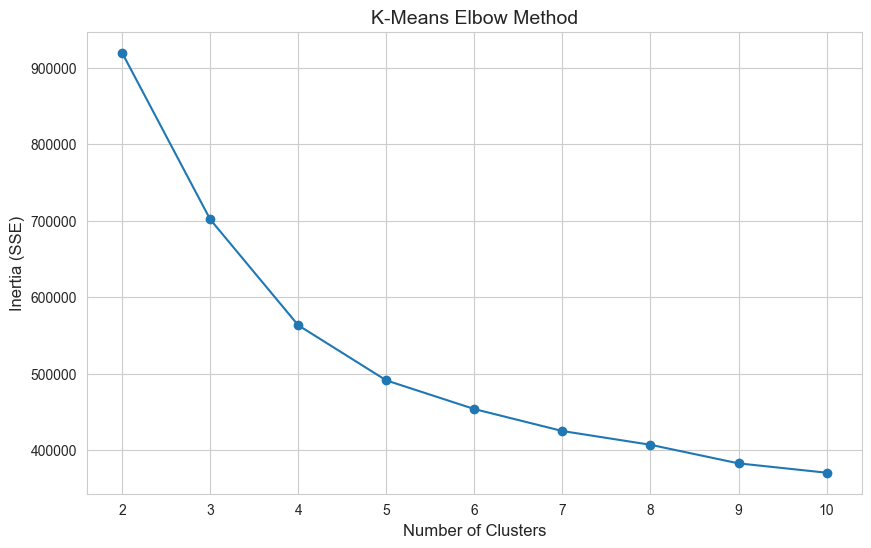

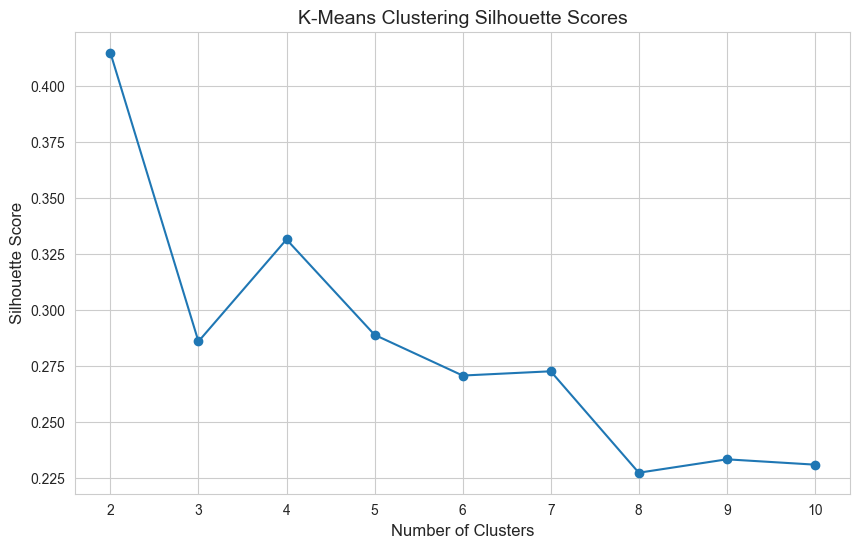

Optimal number of clusters determined by silhouette score: 2
K-Means clustering results saved.


C:\Users\saisu\AppData\Local\Temp\ipykernel_39660\3134154817.py:42: UserWarning: Mismatched number of handles and labels: len(handles) = 0 len(labels) = 2
  plt.legend(handles=handles, labels=cluster_df['Cluster'].unique(),
C:\Users\saisu\AppData\Local\Temp\ipykernel_39660\3134154817.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(handles=handles, labels=cluster_df['Cluster'].unique(),


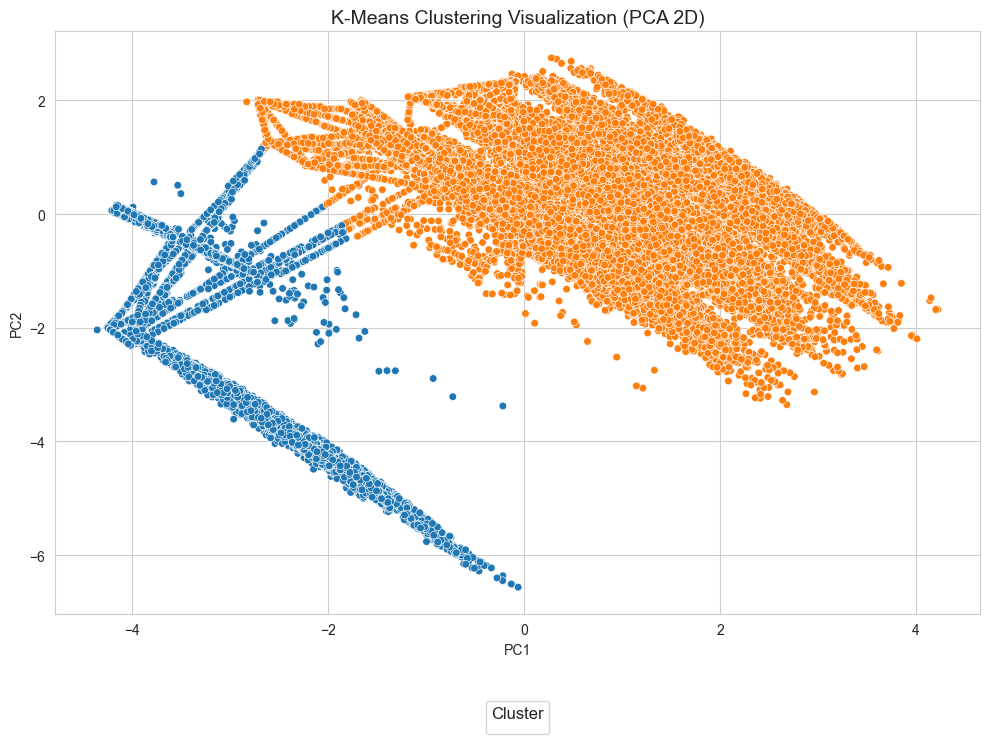

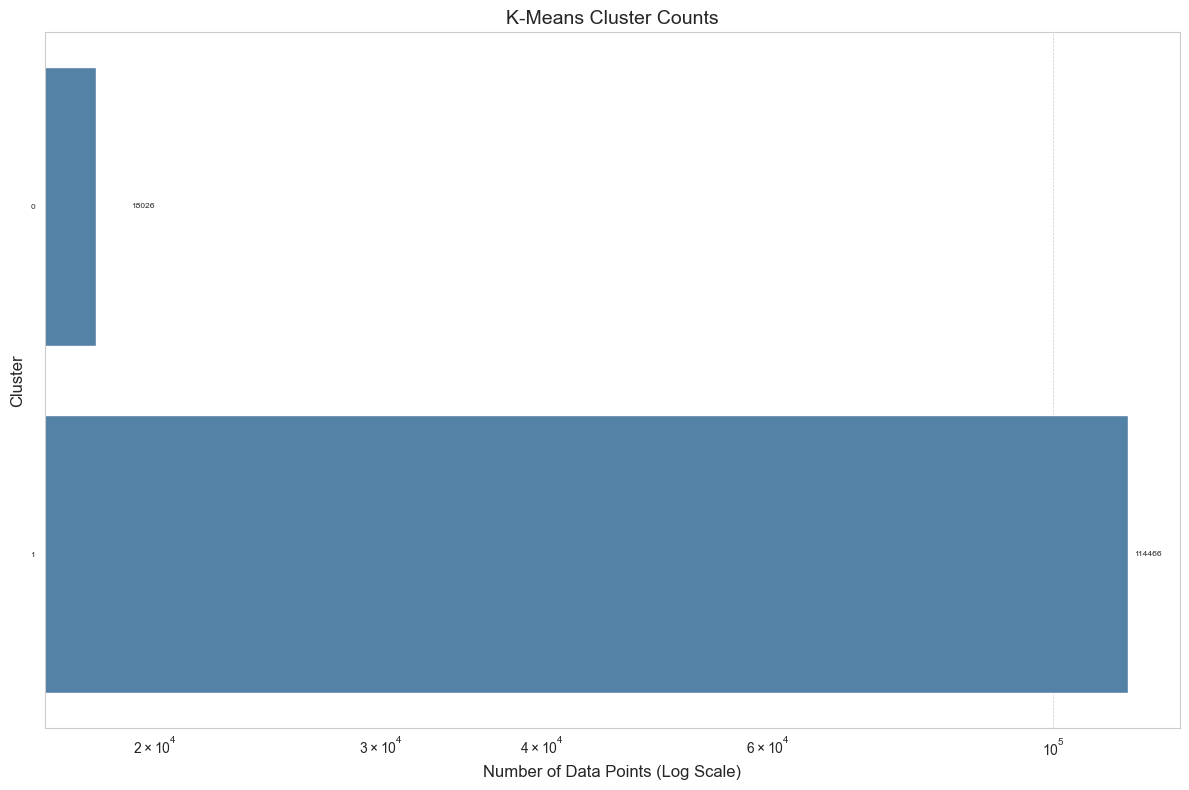

K-Means cluster profiles saved to Results/Comparison_of_Clustering_Delivery\k-means_cluster_profiles.csv

K-Means Cluster Profiles:
         Time_taken (min)  Delivery_person_Age  Restaurant_latitude  \
Cluster                                                               
0               -0.158302            -0.500795            -1.849397   
1                0.024929             0.078865             0.291241   

         Restaurant_longitude  Delivery_location_latitude  \
Cluster                                                     
0                   -2.334376                   -1.257976   
1                    0.367615                    0.198105   

         Delivery_location_longitude  Vehicle_condition  multiple_deliveries  \
Cluster                                                                        
0                          -1.720982           0.501329            -0.097393   
1                           0.271019          -0.078949             0.015337   

         Weather_

C:\Users\saisu\AppData\Local\Temp\ipykernel_39660\3134154817.py:42: UserWarning: Mismatched number of handles and labels: len(handles) = 0 len(labels) = 437
  plt.legend(handles=handles, labels=cluster_df['Cluster'].unique(),
C:\Users\saisu\AppData\Local\Temp\ipykernel_39660\3134154817.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(handles=handles, labels=cluster_df['Cluster'].unique(),


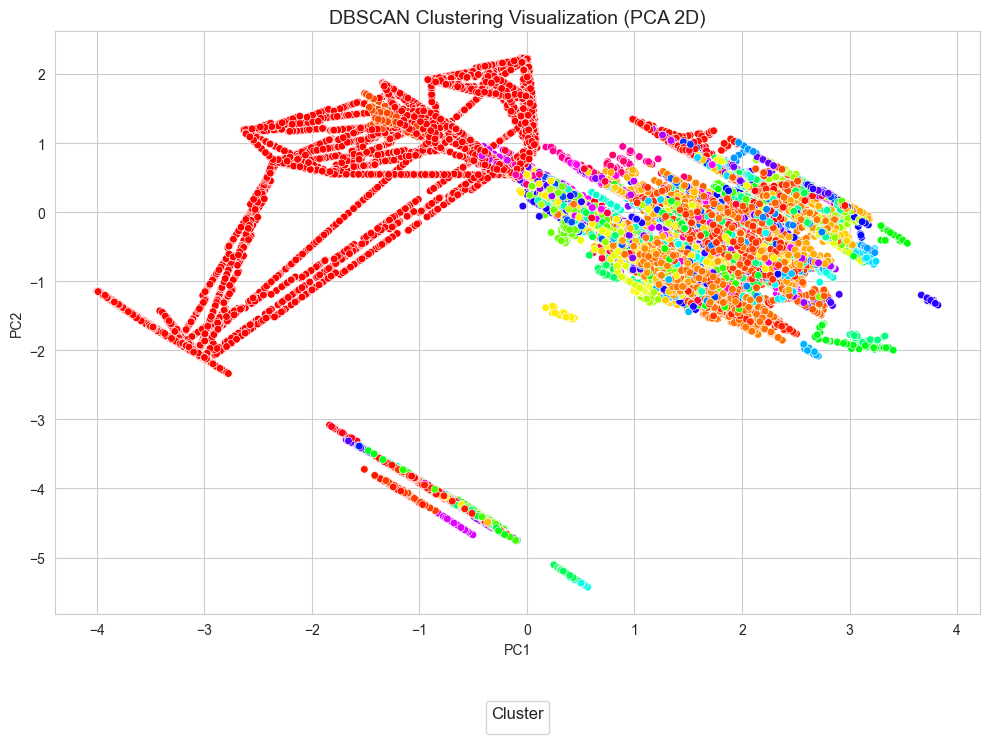

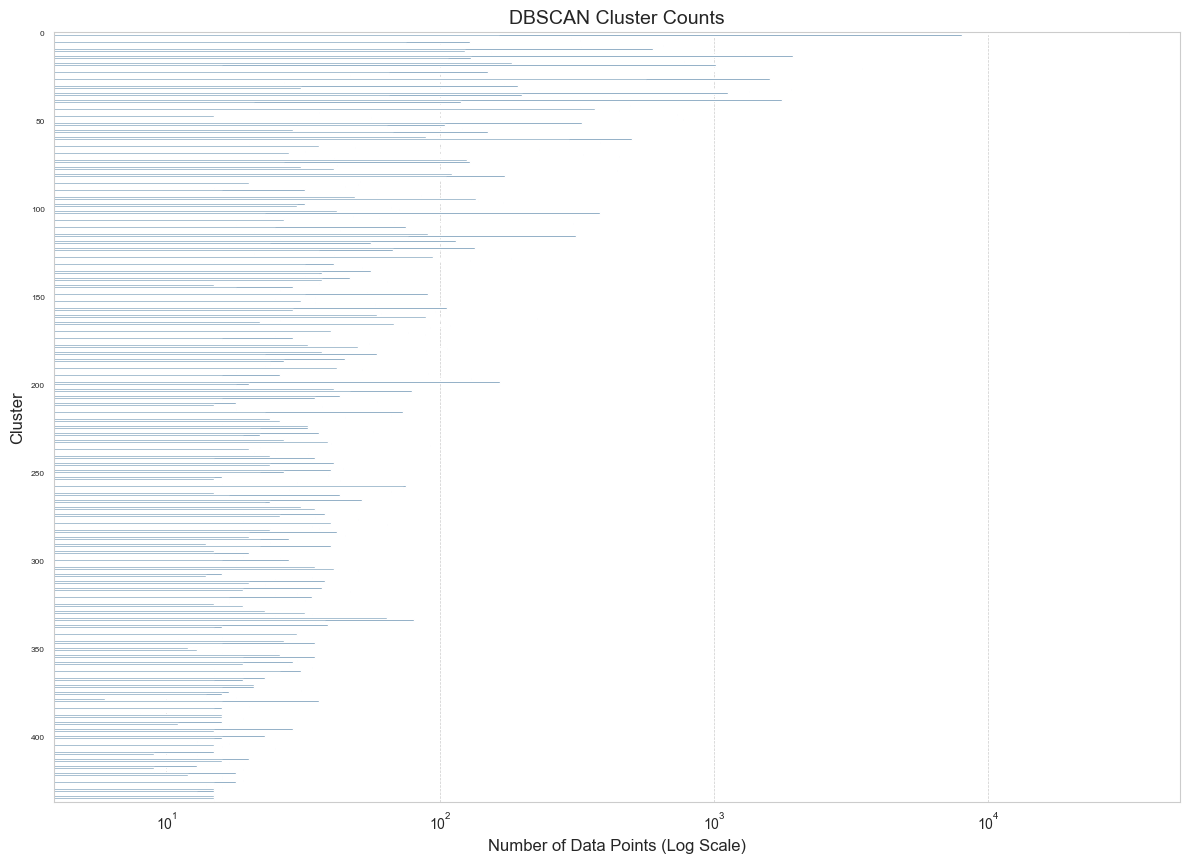

DBSCAN cluster profiles saved to Results/Comparison_of_Clustering_Delivery\dbscan_cluster_profiles.csv

DBSCAN Cluster Profiles:
         Time_taken (min)  Delivery_person_Age  Restaurant_latitude  \
Cluster                                                               
0               -0.442884            -1.212031            -0.174063   
1               -0.380729            -1.212031            -2.573961   
2                0.195704             1.113006             1.105321   
3                0.418012            -0.452580             1.168820   
4                0.592135             0.107585            -1.177204   
...                   ...                  ...                  ...   
432             -0.441109             0.370385             1.130183   
433             -1.571945             0.047756            -0.148490   
434              0.925317             1.158426             0.789176   
435             -1.571945             1.215365            -0.118410   
436             -1.

C:\Users\saisu\AppData\Local\Temp\ipykernel_39660\3134154817.py:42: UserWarning: Mismatched number of handles and labels: len(handles) = 0 len(labels) = 2
  plt.legend(handles=handles, labels=cluster_df['Cluster'].unique(),
C:\Users\saisu\AppData\Local\Temp\ipykernel_39660\3134154817.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(handles=handles, labels=cluster_df['Cluster'].unique(),


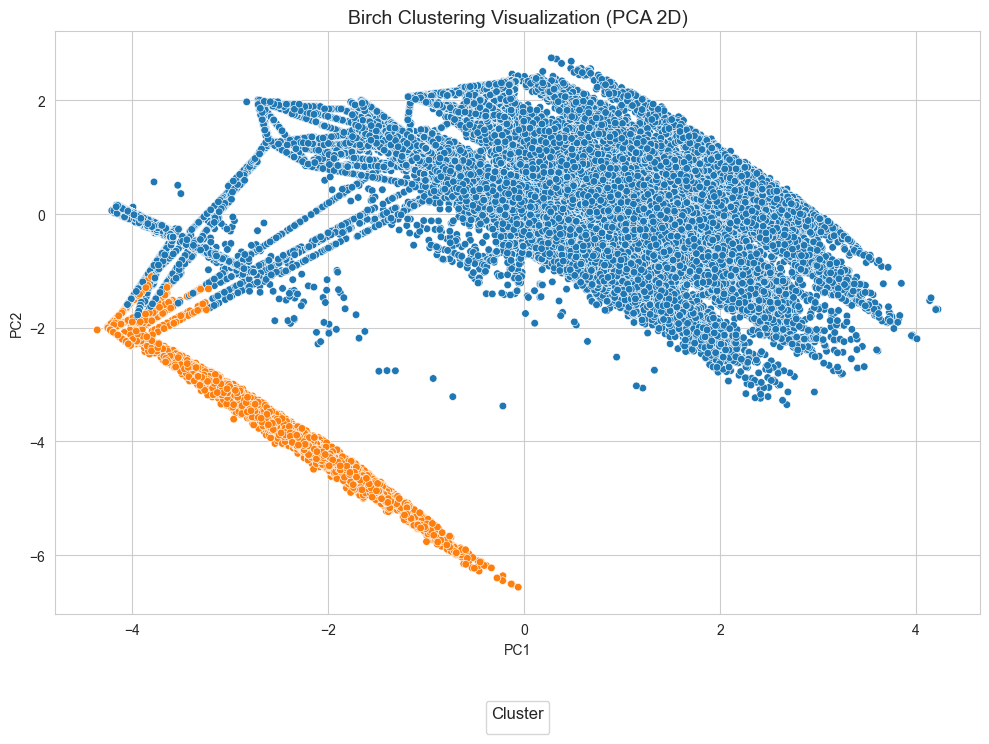

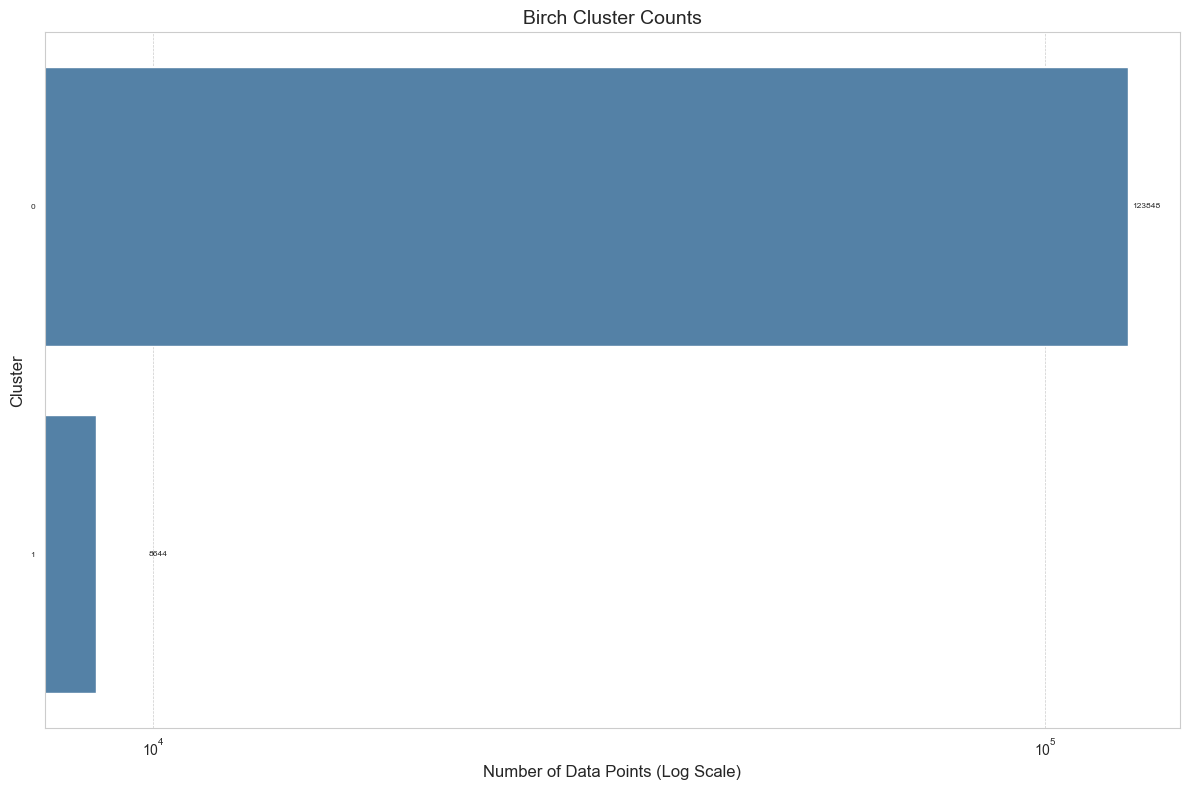

Birch cluster profiles saved to Results/Comparison_of_Clustering_Delivery\birch_cluster_profiles.csv

Birch Cluster Profiles:
         Time_taken (min)  Delivery_person_Age  Restaurant_latitude  \
Cluster                                                               
0               -0.005906            -0.017042             0.082345   
1                0.084617             0.244172            -1.179802   

         Restaurant_longitude  Delivery_location_latitude  \
Cluster                                                     
0                    0.104311                    0.170792   
1                   -1.494532                   -2.447039   

         Delivery_location_longitude  Vehicle_condition  multiple_deliveries  \
Cluster                                                                        
0                           0.255387           0.016291             0.006407   
1                          -3.659091          -0.233415            -0.091795   

         Weather_condit

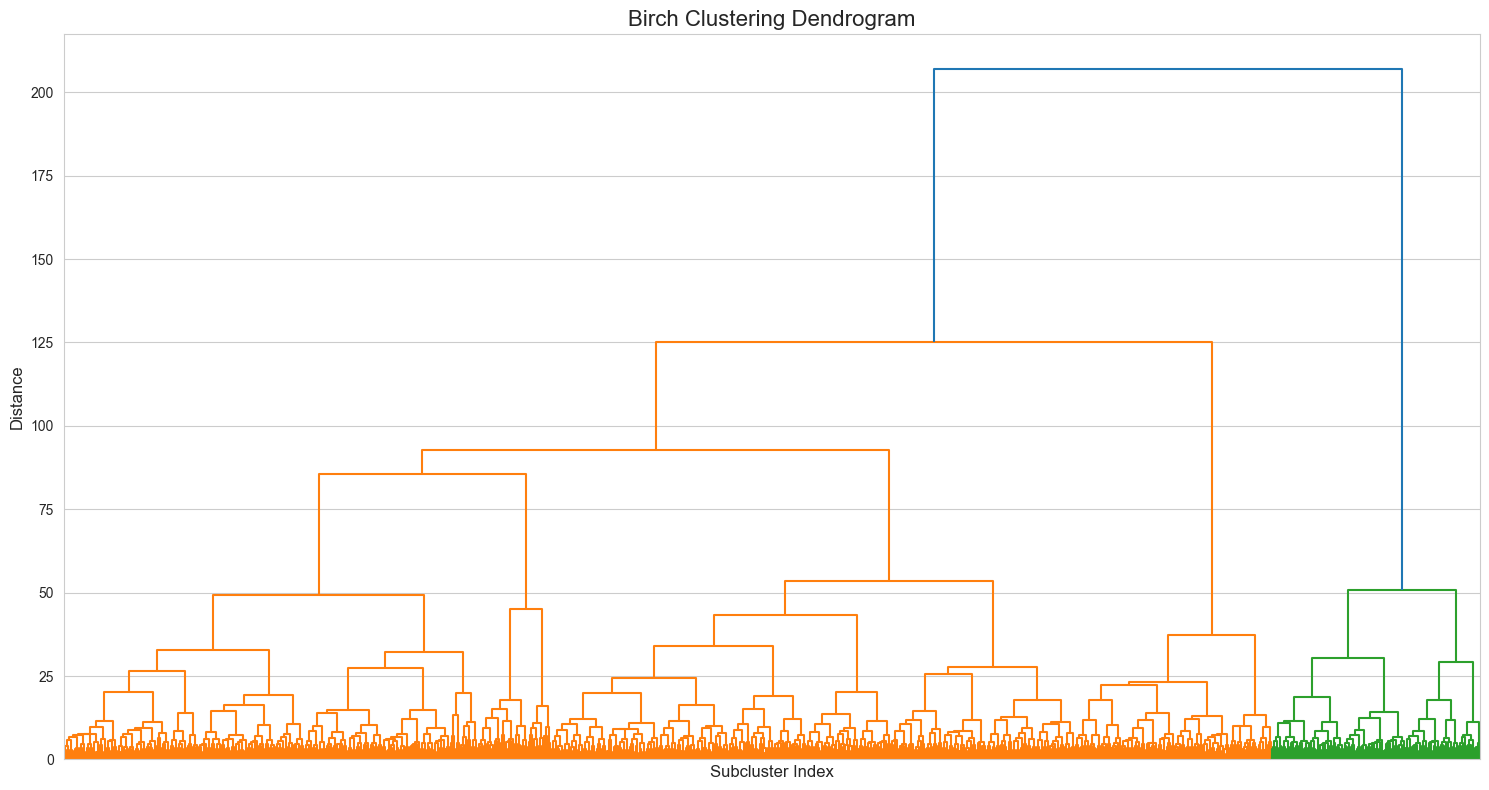

Birch Clustering Evaluation:
 - Silhouette Score: 0.410
 - Davies-Bouldin Index: 0.936
 - Calinski-Harabasz Index: 28285.033

Birch evaluation metrics saved to Results/Comparison_of_Clustering_Delivery\birch_evaluation.txt

Comparison of Clustering Algorithms:
    method  silhouette_score  davies_bouldin_index  calinski_harabasz_index
0  K-Means          0.414787              1.319671             42819.013399
1   DBSCAN          0.142637              0.809104               708.314507
2    Birch          0.410044              0.935983             28285.032724
Comparison metrics saved to Results/Comparison_of_Clustering_Delivery\clustering_algorithms_comparison.csv


C:\Users\saisu\AppData\Local\Temp\ipykernel_39660\1730429348.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='method', y='silhouette_score', data=df_metrics, palette='viridis')


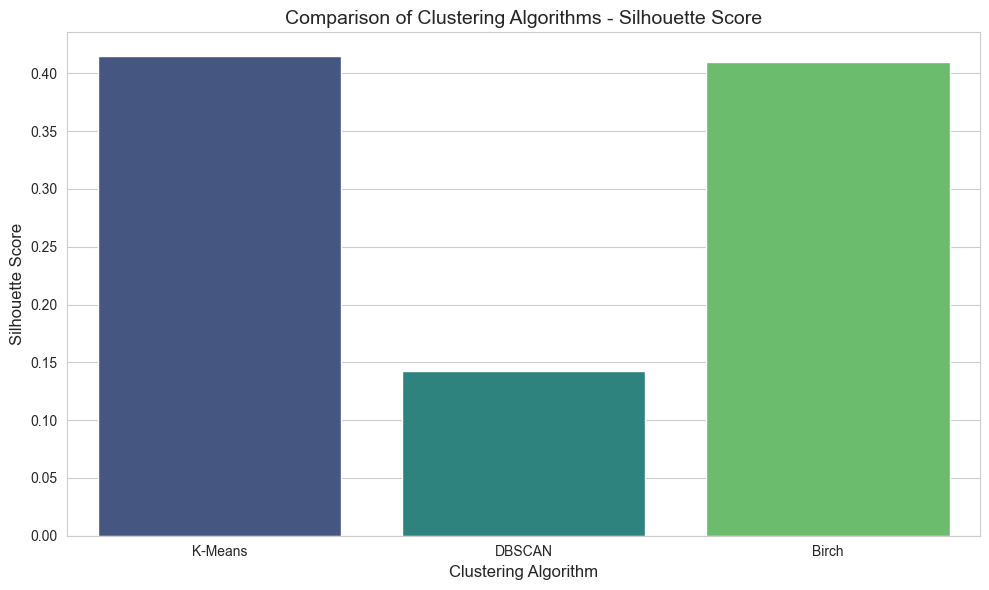

C:\Users\saisu\AppData\Local\Temp\ipykernel_39660\1730429348.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='method', y='davies_bouldin_index', data=df_metrics, palette='magma')


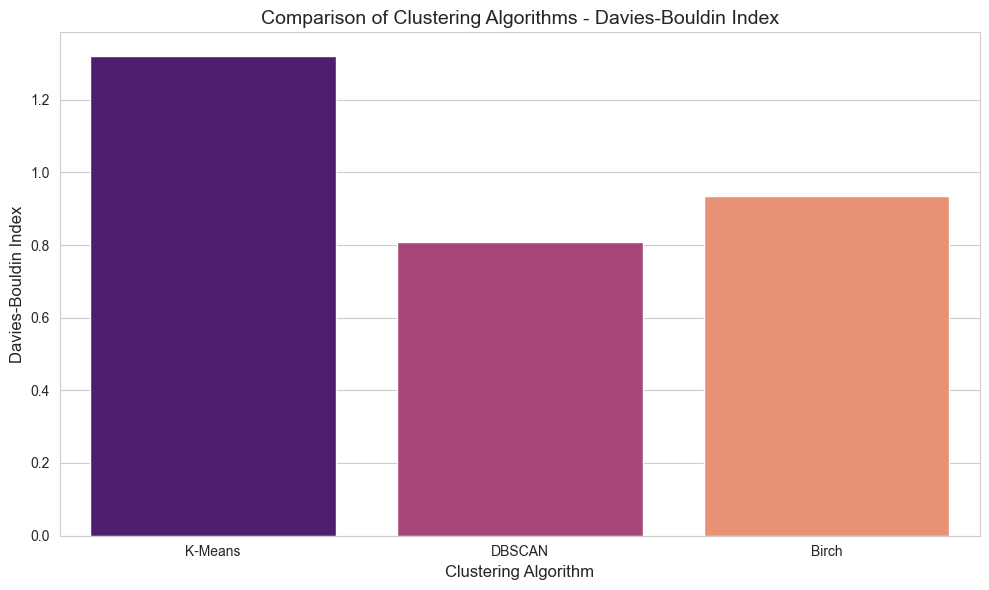

C:\Users\saisu\AppData\Local\Temp\ipykernel_39660\1730429348.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='method', y='calinski_harabasz_index', data=df_metrics, palette='coolwarm')


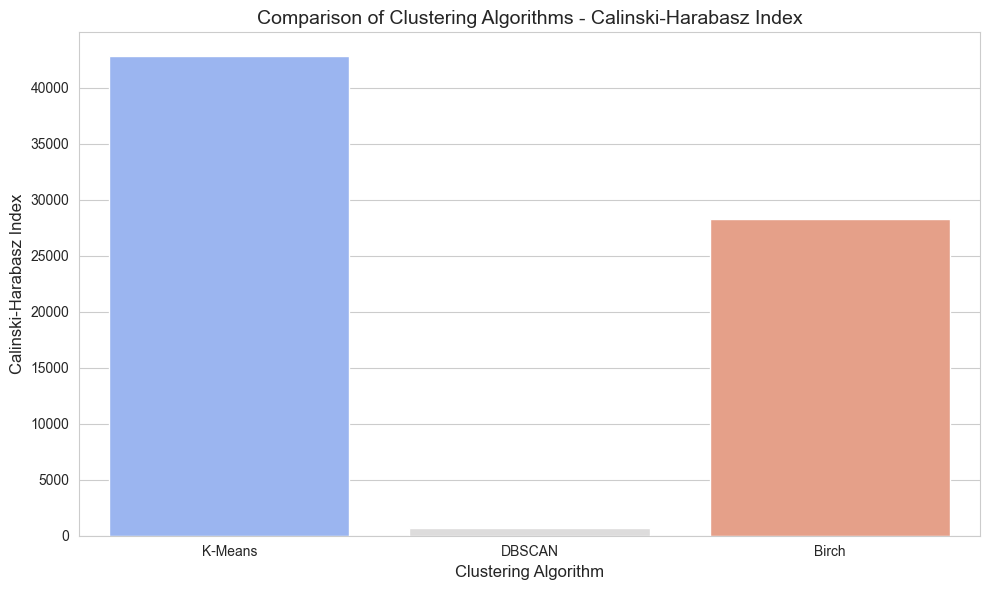

In [18]:
# Run the main function
main()